In [2]:
import msgpack
import torch
import numpy
import matplotlib.pyplot as plt
from model import SignalNet
from PIL import Image
plt.rcParams['figure.figsize'] = [20, 10]

def FromMessagePack(filename):
    with open(filename, "rb") as data_file:
        byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data)
    return data_loaded

id = 2
width = 512
path = "C:\Projects\MMU\Ifosic\src\Python"
filename = f"{path}\Set0{id}.msgpack";
data = FromMessagePack(filename)
traces = numpy.array(data["Traces"])
tracesT = numpy.transpose(traces, (1,0))
h, _ = tracesT.shape
img = Image.fromarray(tracesT)
imgR = img.resize((width, h))
inputs = numpy.array(imgR)

indexes = data["BoundaryIndexes"]
print(indexes)
print(traces.shape, tracesT.shape)

[656, 682, 717, 739, 780, 817, 851]
(994, 1950) (1950, 994)


In [4]:
from prepare import NumberToGrid

ng = NumberToGrid(-20, 30, 64)
ng.getClass(27)

array([60], dtype=int64)

In [29]:
from prepare import NumberToGrid

ng = NumberToGrid(-20, 30, 64)
i5 = FromMessagePack(f"{path}\Set05.msgpack")
i5 = numpy.array(i5)
di, dl = torch.load(f"{path}\dataset.pth")
l4 = dl[2* 1950:3*1950]
print(i5.shape, l4.shape)
# h,w = inputs.shape
# width = w // 2
# n = int(w / width)
ex = i5#.reshape(h, n, width)

grid = torch.zeros(ex.shape[0], ex.shape[1], ng.length)
for i,v in enumerate(ex):
    grid[i] = ng.items(v)

torch.save((grid.unsqueeze(1), l4), f"{path}\dataset5.pth")
# # plt.plot(inputs[800*2])
# plt.imshow(grid[800*2])
# plt.show()


(1950, 512) torch.Size([1950])


In [31]:
import torch
import math

inputs, labels = torch.load(f"{path}\dataset_512_64_allnew.pth")
# g = 256
# grids = inputs.reshape(inputs.shape[0], 1, inputs.shape[2] // g, g, inputs.shape[3])
# grid0 = grids[:, :, 0, :, :]
# grid1 = grids[:, :, 1, :, :]
# torch.save((grid0, labels), f"{path}\dataset_256_64_0.pth")
# torch.save((grid1, labels), f"{path}\dataset_256_64_1.pth")
# plt.imshow(img[800,0])
#grids[:,:inputs.shape[1]] = inputs
print(inputs.shape, labels.shape)

# l4 = dl[1* 1950:2*1950]

# h,w = inputs.shape
# width = w // 2
# n = int(w / width)
# ex = inputs#.reshape(h, n, width)
# print(ex.shape)

# grid = torch.zeros(ex.shape[0], ex.shape[1], ng.length)
# for i,v in enumerate(ex):
#     grid[i] = ng.items(v)

# torch.save((grid.unsqueeze(1), l4), f"{path}\dataset4.pth")
# # plt.plot(inputs[800*2])
# plt.imshow(grid[800*2])
# plt.show()

torch.Size([21450, 1, 512, 64]) torch.Size([21450])


In [8]:
di, dl = torch.load(f"{path}\dataset.pth")
i1 = torch.load(f"{path}\Set01_2.pth").reshape(1950, 2, 512, 64)
i2 = torch.load(f"{path}\Set02_2.pth").reshape(1950, 2, 512, 64)
i3 = torch.load(f"{path}\Set03_2.pth").reshape(1950, 2, 512, 64)
gi = 1
ix = torch.cat((i1[:,gi,:,:], i2[:,gi,:,:], i3[:,gi,:,:]))
ix = ix.unsqueeze(1)
print(ix.shape, dl.shape)
# l = torch.zeros(dl.shape[0], 2)
# l[:,0] = dl
# l[:,1] = dl
# lx = l.reshape(-1)
#torch.save((ix, dl), f"{path}\dataset_{gi}.pth")

torch.Size([5850, 1, 512, 64]) torch.Size([5850])


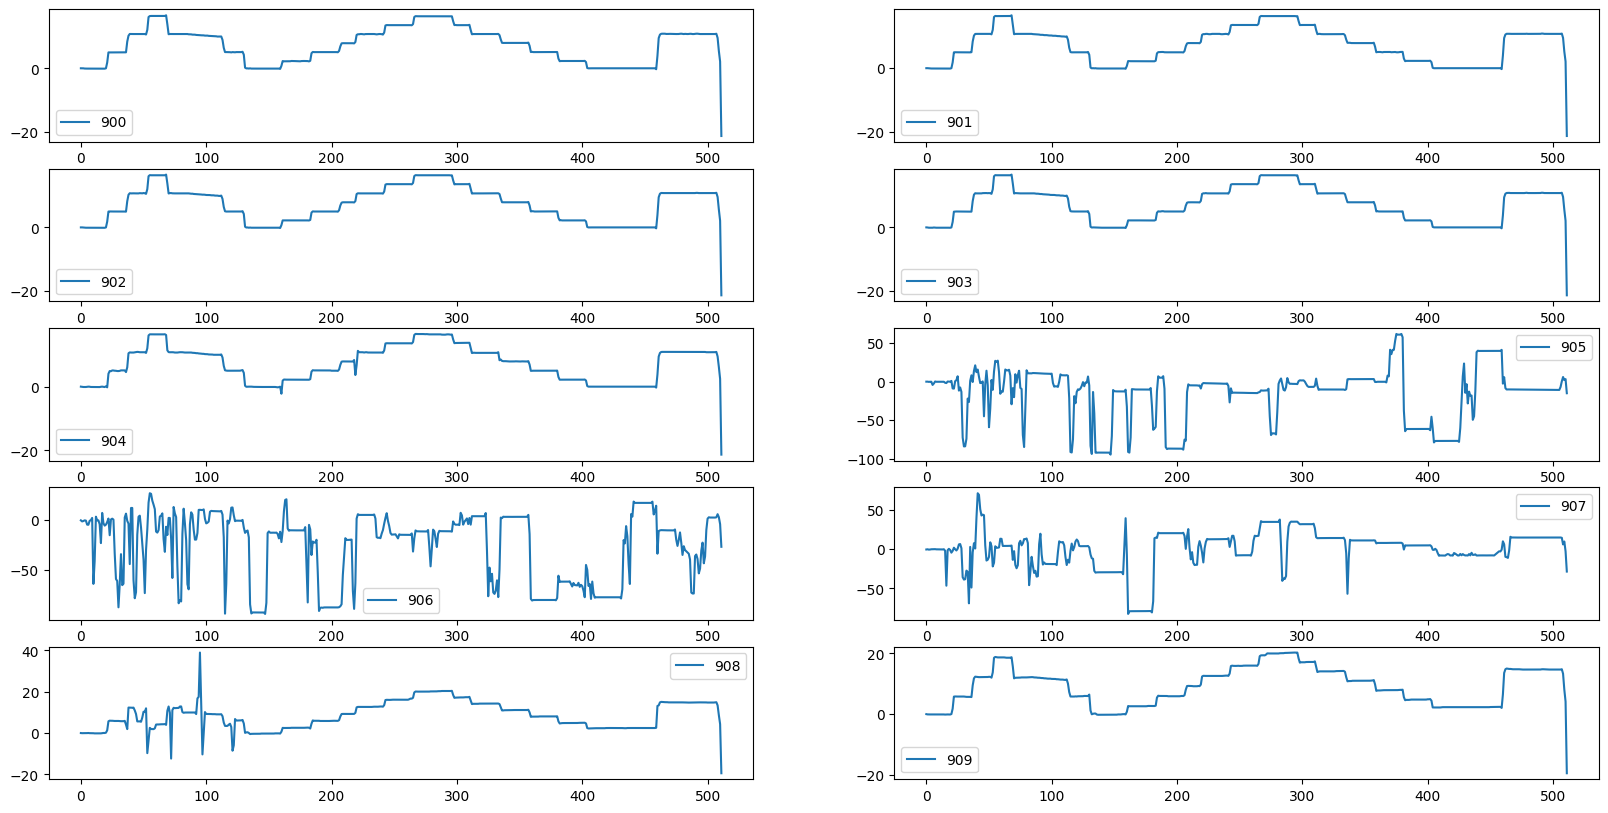

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import math

def signal_plot(c: list, roi):
    n = len(c)
    if n == 1:
        plt.plot(roi[c[0]])
    else:
        cols = 2
        rows = math.ceil(n / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= n:
                    break
                v = c[i]
                ax[row, col].plot(roi[v])
                ax[row, col].legend([v])
                i += 1
    plt.show()

signal_plot(np.arange(900,910), inputs)

In [48]:
from scipy.spatial.distance import euclidean
import math

def win(pos = 654, w = 5):
    h = w // 2
    return np.arange(pos-h, pos+h+1)

def data_slider(data: torch.tensor, win = 5):
    h,w = data.shape
    hw = win // 2
    slider = torch.zeros(data.shape[0], win, data.shape[1])
    for i in range(win):
        ss = 0 if i > hw else hw-i
        se = 0 if i < hw else i-hw
        ds = 0 if i < hw else i-hw
        de = 0 if i > hw else hw-i
        # print(ss, se, ds, de)
        slider[ss:h-se,i,:] = data[ds:h-de]
    return slider

def signal_plot(data: torch.tensor, idx = 0):
    b,c,w = data.shape
    win = data[idx]
    if c == 1:
        plt.plot(win[0])
    else:
        cols = 2
        rows = math.ceil(c / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= c:
                    break
                v = idx-2+i
                ax[row, col].plot(win[i])
                ax[row, col].legend([v])
                i += 1
    plt.show()

def sliding_distance(cur: torch.tensor):
    mid = len(cur) // 2
    sum = 0
    for i,c in enumerate(cur):
        if (i == mid):
            continue
        d = euclidean(c, cur[mid])
        sum += d
    return sum / (len(cur) - 1)

In [28]:
from UNet import UNet
import torch
from matplotlib import pyplot as plt


model = UNet()
path = r'C:\\Projects\\MMU\\Ifosic\\src\\Python'
model.load_state_dict(torch.load(f"{path}\\model.pth"))
inputs,labels = torch.load(f"{path}\\dataset_256_64.pth")
print(inputs.shape)
scores = model(inputs)
y = scores.argmax(1)

torch.Size([1950, 1, 512, 64])


torch.Size([1950])
torch.Size([1950, 512])


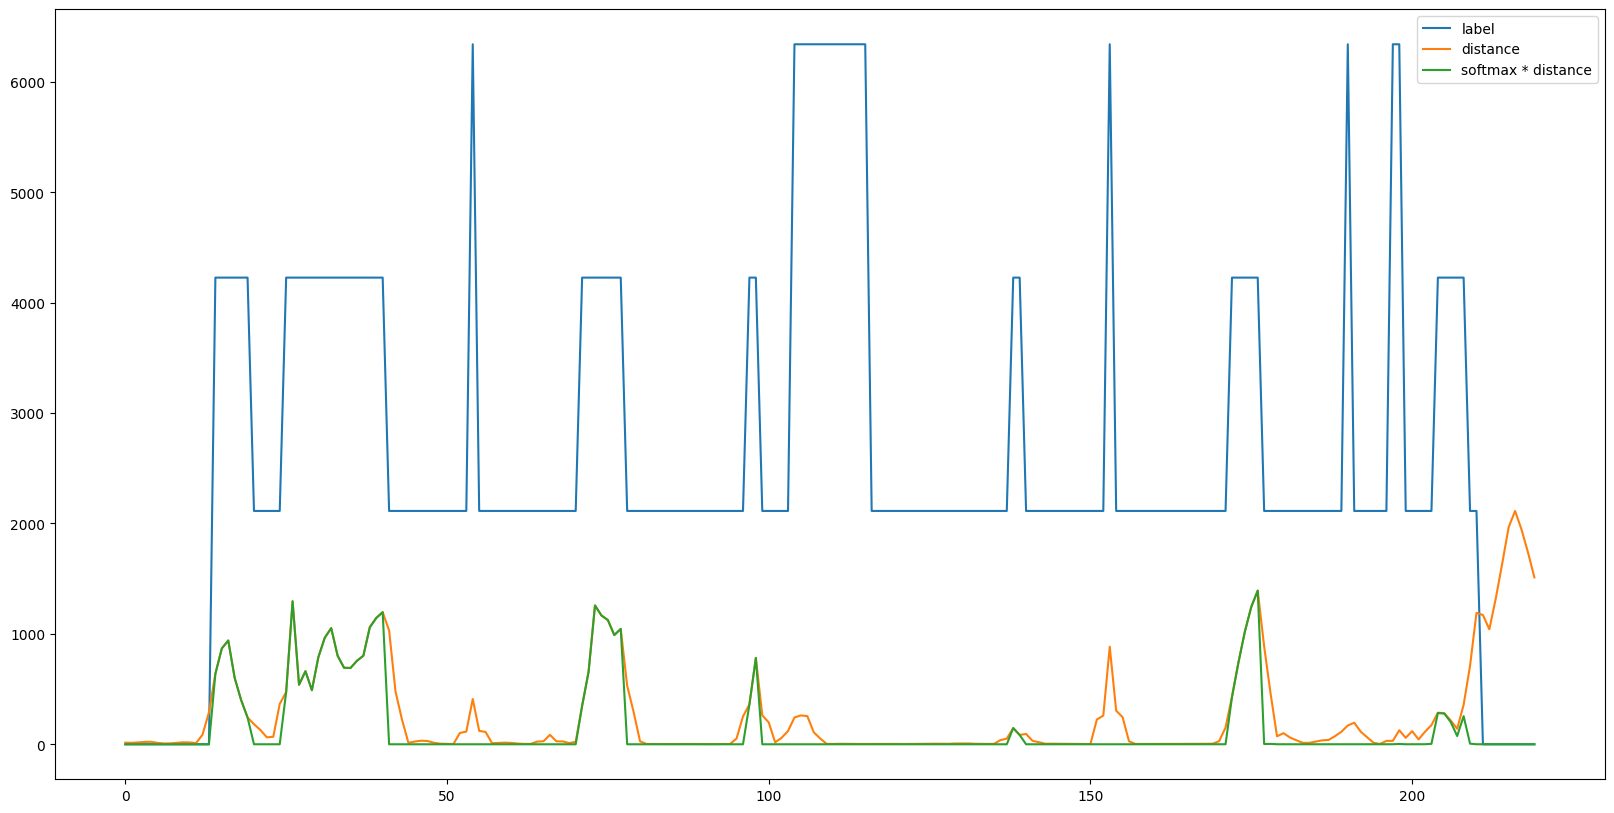

In [57]:
from torch import nn

softmax = nn.Softmax(dim=1)
yp = softmax(scores)
yt = yp[:,2].detach()
print(yt.shape)

i5 = FromMessagePack(f"{path}\Set04.msgpack")
i5 = torch.tensor(i5)
print(i5.shape)
sliders = data_slider(i5)
roi = torch.arange(640,860)
distances = torch.zeros(len(roi))
for i,v in enumerate(roi):
    cur = sliding_distance(sliders[v])
    distances[i] = cur

lr = labels[640:860]
yr = y[640:860]
maxD = max(distances)
plt.plot(lr * maxD)
# plt.plot(yr * maxD)
# plt.plot(yt[640:860] * maxD)
plt.plot(distances)
plt.plot(distances * yt[640:860])
plt.legend([
    'label',
    # 'softmax',
    'distance',
    'softmax * distance'
])
plt.show()

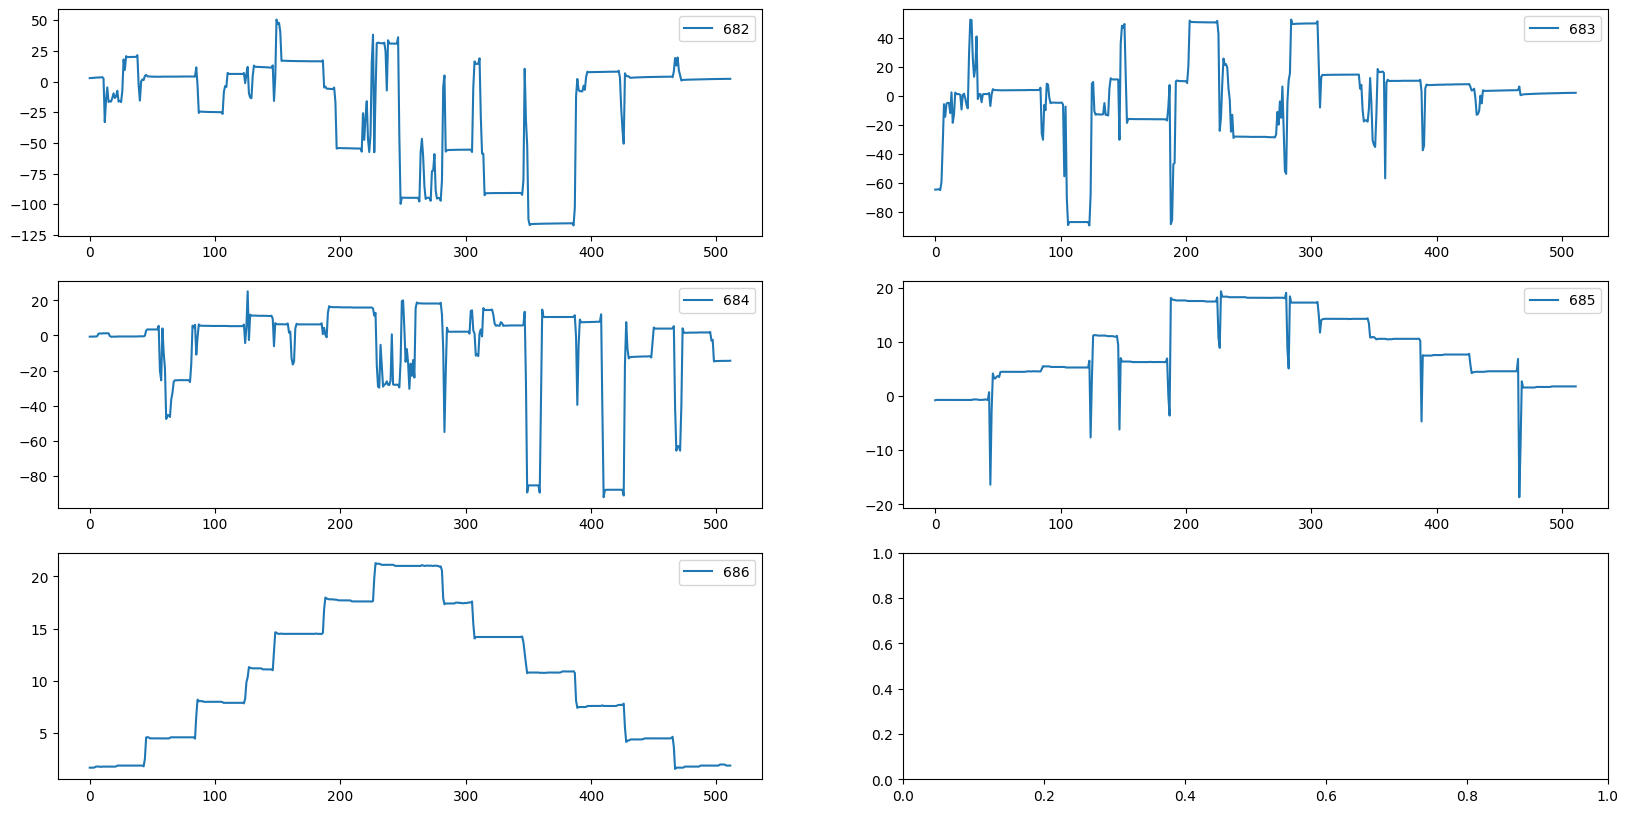

In [54]:
signal_plot(sliders, idx = 684)

torch.Size([1950])
tensor([[2.3463e-06, 9.9994e-01, 5.3844e-05, 1.0168e-07],
        [8.3058e-06, 9.9972e-01, 2.7356e-04, 1.1687e-06],
        [2.7285e-04, 5.1938e-06, 9.9702e-01, 2.7021e-03],
        [2.8717e-02, 4.2574e-02, 9.2871e-01, 2.5655e-07],
        [7.5919e-06, 9.9896e-01, 1.0348e-03, 3.3835e-07],
        [1.2652e-05, 9.9923e-01, 7.6226e-04, 1.5959e-07],
        [8.1041e-06, 9.9810e-01, 1.8941e-03, 6.6369e-08],
        [6.2359e-06, 9.9450e-01, 5.4889e-03, 2.1329e-07],
        [2.1450e-05, 9.9901e-01, 9.6517e-04, 6.5933e-07],
        [3.9517e-05, 9.9554e-01, 4.4226e-03, 1.2862e-06]],
       grad_fn=<SliceBackward0>)
tensor([1, 1, 3, 3, 1, 1, 1, 1, 1, 1])


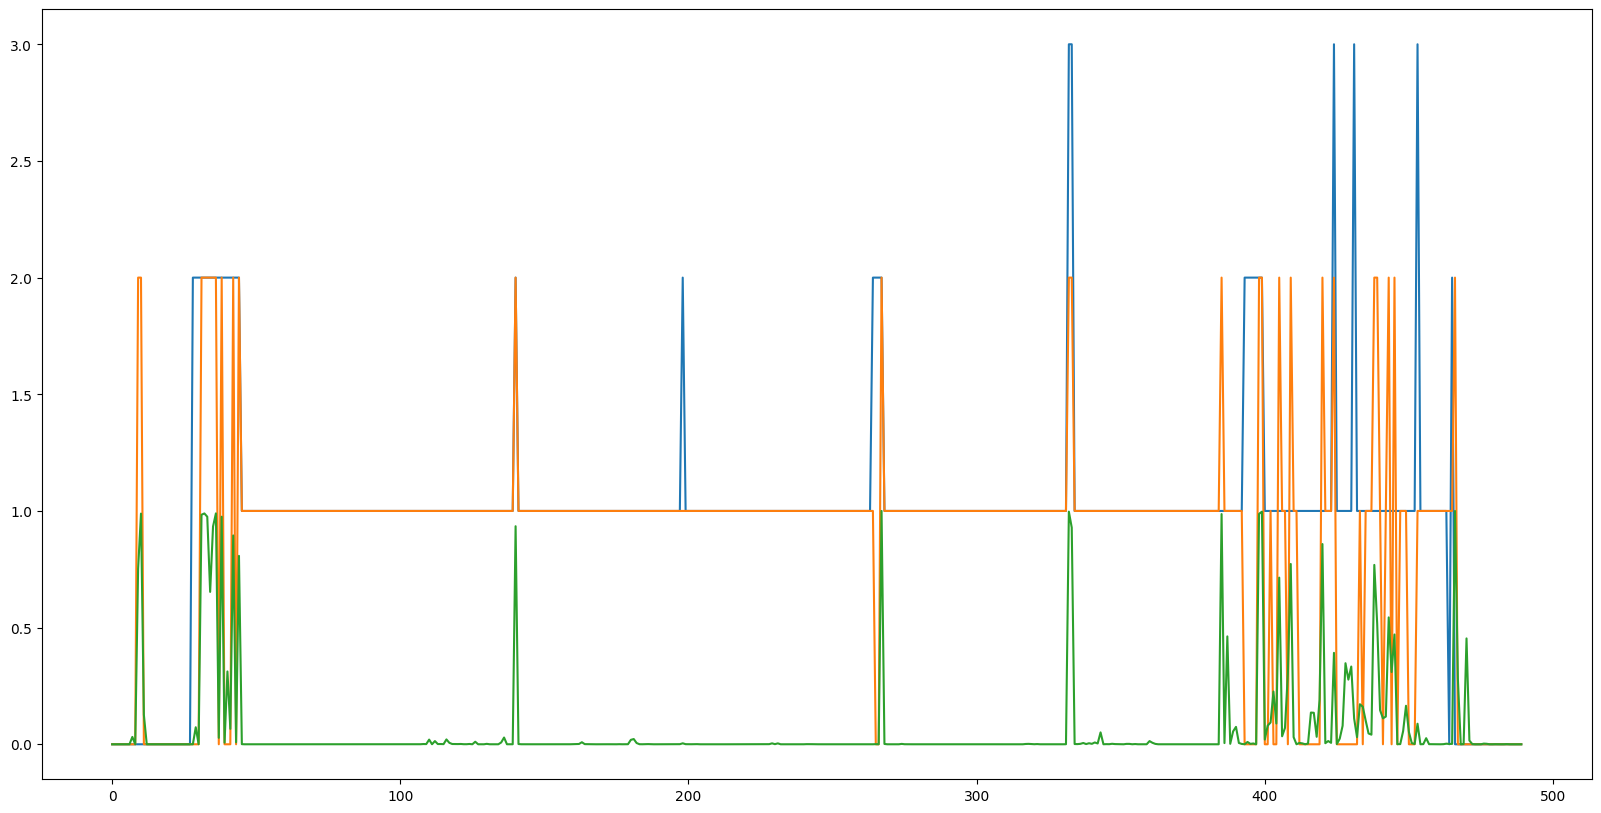

In [82]:

l = labels[970:980]
print(yp[970:980])
print(l)
plt.plot(labels[640:1130])
plt.plot(y[640:1130])
plt.plot(yt[640:1130])
plt.show()

In [81]:
print(inputs[976])

(512,)


In [12]:
from torch import nn

softmax = nn.Softmax(dim=1)
print(scores.shape)
yp = softmax(scores)
print(yp[750])

torch.Size([1950, 4])
tensor([1.1623e-05, 1.7594e-03, 3.2956e-05, 9.9820e-01],
       grad_fn=<SelectBackward0>)


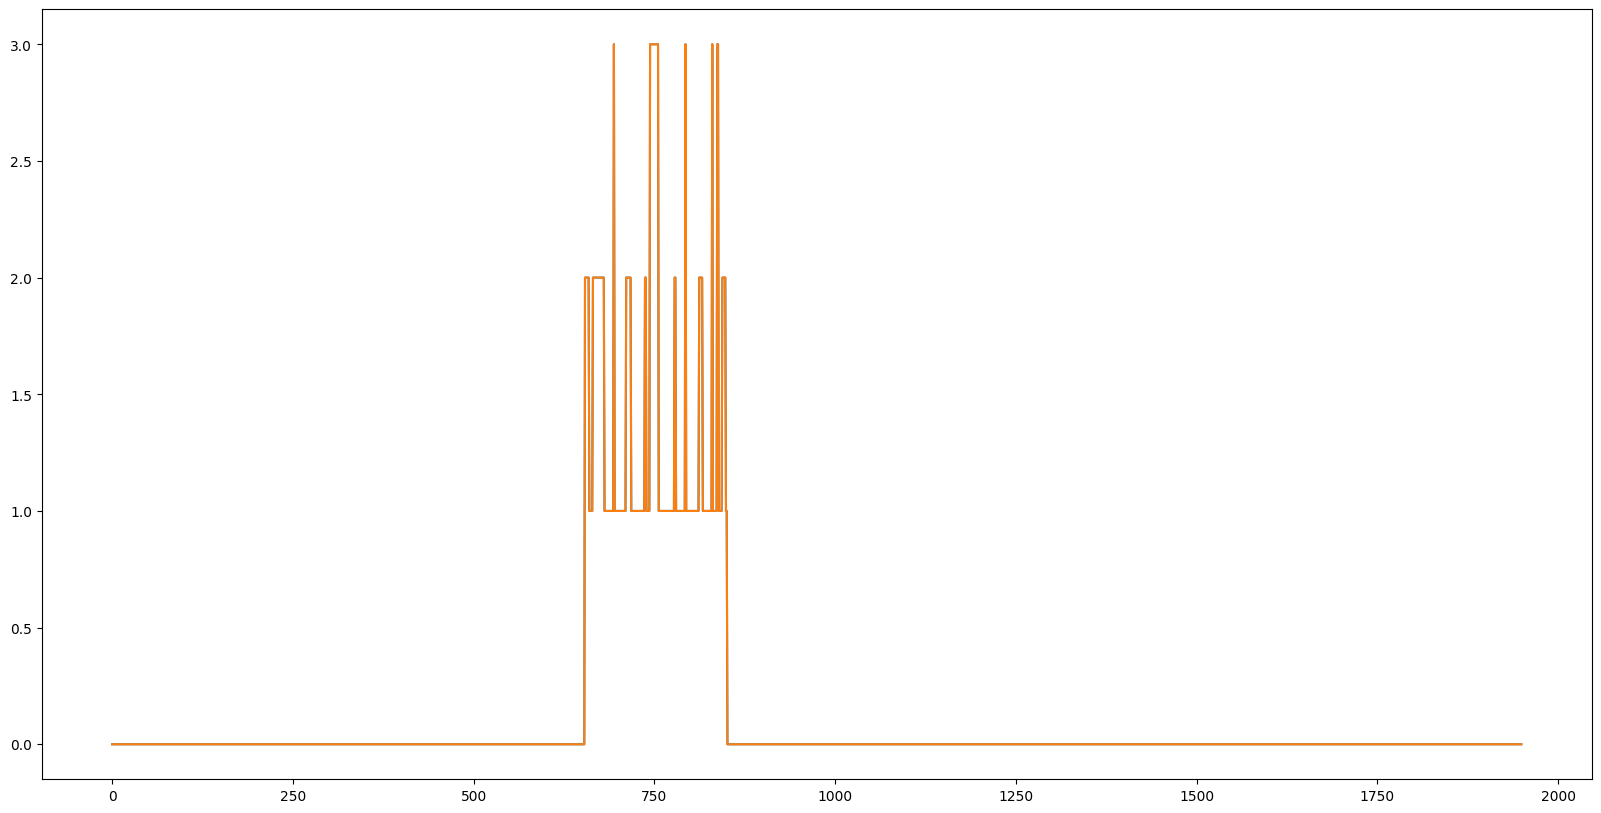

In [6]:
plt.plot(labels)
plt.plot(y)
plt.show()

In [36]:
i1 = torch.arange(640,940)
i2 = torch.arange(650,860) 
i3 = torch.arange(660,1110)
indicies = torch.concat([
    i1+1950*0,
    i2+1950*1,
    i3+1950*2,
    i1+1950*3,
    i2+1950*4,
    i3+1950*5,
    i1+1950*6,
    i2+1950*7,
    i3+1950*8,
    i2+1950*9,
])
print(indicies.shape)


torch.Size([3090])


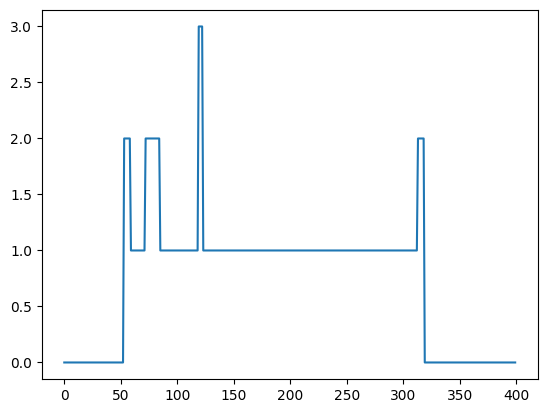

In [ ]:
def data_slider(data: torch.tensor, win = 5):
    h,w = data.shape
    hw = win // 2
    slider = torch.zeros(data.shape[0], win, data.shape[1])
    for i in range(win):
        ss = 0 if i > hw else hw-i
        se = 0 if i < hw else i-hw
        ds = 0 if i < hw else i-hw
        de = 0 if i > hw else hw-i
        # print(ss, se, ds, de)
        slider[ss:h-se,i,:] = data[ds:h-de]
    return slider

slider = data_slider(roi)
model = SignalNet(in_channels=5)
path = r'C:\\Projects\\MMU\\Ifosic\\src\\Python'
model.load_state_dict(torch.load(f"{path}\\model.pth"))
scores = model(slider)
predictedBoundary = torch.argmax(scores, 1)

plt.plot(predictedBoundary)#[600:1000])

1308


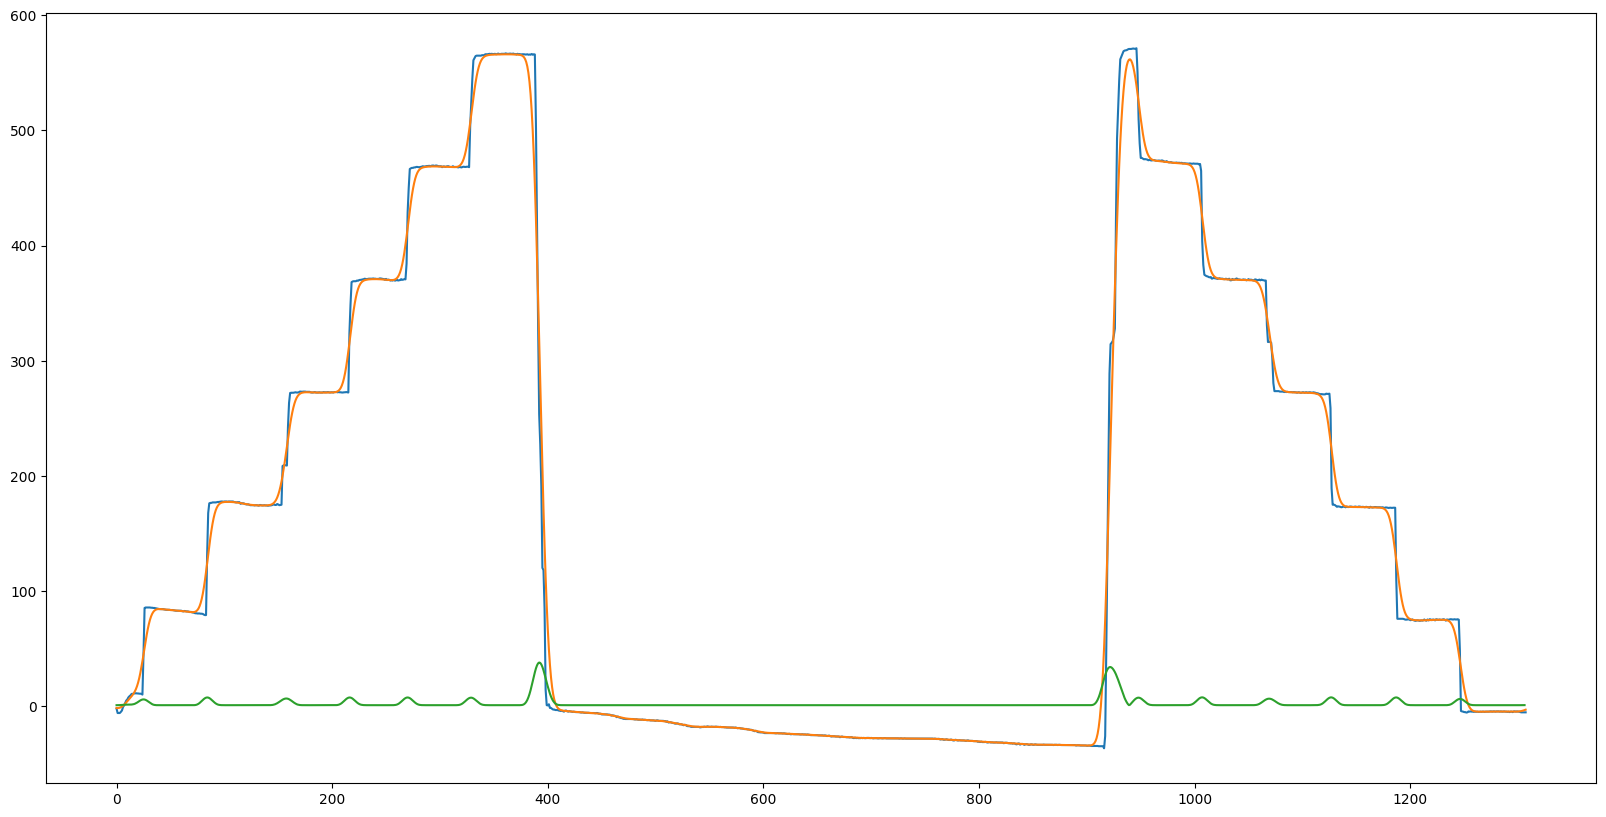

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

sigma1 = 3
sigma2 = 50

def gaussian_filter1d(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

fiberId = 5
candidates = []
cTimes = []
average = {}
for i in range(indexes[fiberId - 1], indexes[fiberId]):
    if predictedBoundary[i] != 1:
        continue
    for j in range(traces.shape[0]):
        candidates.append(traces[j,i])
        cTimes.append(j)
        average[j] = average.get(j, 0) + traces[j,i]

times = np.arange(0, traces.shape[0])
freqSum = np.array([average[k] for k in average.keys()])

kernel = gaussian_filter1d(size=len(times),sigma=5)
print(len(kernel))
# freqSmooth = savitzky_golay(freqSum, 51, 3)
freqSmooth = np.convolve(freqSum, kernel, mode='same')
distances = []
for key in range(len(freqSmooth) - 1):
    distances.append(euclidean([key, freqSmooth[key]],[key+1, freqSmooth[key+1]]))

# plt.scatter(times, freqSum)
# plt.scatter(times, freqSmooth)
plt.plot(freqSum)
plt.plot(freqSmooth)
plt.plot(distances)

step_indx = np.argmax(freqSmooth)
# fig,ax = plt.subplots(1,2)
# ax[0].plot(gaussian_filter1d(size=365,sigma=sigma1))
# ax[0].set_title(f'sigma= {sigma1}')
# ax[1].plot(gaussian_filter1d(size=365,sigma=sigma2))
# ax[1].set_title(f'sigma= {sigma2}')
plt.show()